<a href="https://colab.research.google.com/github/OleksiiLatypov/DS_HW_1/blob/master/DS_HW_11/DS_HW_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

**Download the Dataset**

In [3]:
# Load the IMDB Reviews dataset
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)

In [ ]:
print(info)

In [4]:
dataset_info = info

# Create a dictionary with the extracted information
data_dict = {
    "Split": ["train", "test", "unsupervised"],
    "Number of Examples": [dataset_info.splits["train"].num_examples, dataset_info.splits["test"].num_examples, dataset_info.splits["unsupervised"].num_examples],
    "Features": [dataset_info.features, dataset_info.features, dataset_info.features],
    "Labels": [dataset_info.features["label"].names, dataset_info.features["label"].names, dataset_info.features["label"].names],
    # Add other relevant information here
}


df = pd.DataFrame(data_dict)
df

,Split,Number of Examples,Features,Labels
0,train,25000,"(text, label)","[neg, pos]"
1,test,25000,"(text, label)","[neg, pos]"
2,unsupervised,50000,"(text, label)","[neg, pos]"


As we can see in the output above, there is a total of 100,000 examples in the dataset and it is split into train, test and unsupervised sets.

**Split the dataset**

In [ ]:
# Print the contents of the dataset you downloaded
print(imdb)

In [7]:
train_data, test_data = imdb["train"], imdb["test"]

# Take 1 training examples and print its contents
for i in train_data.take(1):
  print(i)

(<tf.Tensor: shape=(), dtype=string, numpy=b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.">, <tf.Tensor: shape=(), dtype=int64, numpy=0>)


In [16]:
# Initialize sentences and labels lists
train_sentences = []
train_labels = []

test_sentences = []
test_labels = []

# Loop over all training examples and save the sentences and labels
for s, l in train_data:
  train_sentences.append(s.numpy().decode('utf-8'))
  train_labels.append(l.numpy())

for i, text in zip(train_labels[:6], train_sentences[:6]):
  print(f'label {i}: {text[:150]}...')


label 0: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be the...
label 0: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable ...
label 0: Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem...
label 1: This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chai...
label 1: As others have mentioned, all the women that go nude in this film are mostly absolutely gorgeous. The plot very ably shows the hypocrisy of the female...
label 1: This is a film which should be seen by anybody interested in, effected by, or suffering from an eating disorder. It is an amazingly accurate and sensi...


In [15]:
for s, l in test_data:
  test_sentences.append(s.numpy().decode('utf-8'))
  test_labels.append(l.numpy())

for i, text in zip(test_labels[:6], test_sentences[:6]):
  print(f'label {i}: {text[:150]}...')



label 1: There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add...
label 1: A blackly comic tale of a down-trodden priest, Nazarin showcases the economy that Luis Bunuel was able to achieve in being able to tell a deeply human...
label 0: Scary Movie 1-4, Epic Movie, Date Movie, Meet the Spartans, Not another Teen Movie and Another Gay Movie. Making "Superhero Movie" the eleventh in a s...
label 0: Poor Shirley MacLaine tries hard to lend some gravitas to this mawkish, gag-inducing "feel-good" movie, but she's trampled by the run-away sentimental...
label 1: As a former Erasmus student I enjoyed this film very much. It was so realistic and funny. It really picked up the spirit that exists among Erasmus stu...
label 1: My God, Ryan Gosling has made a lot of deep characters in his career, this is one of his wonderful acting jobs. For me this is a very deep movie, need...


In [10]:
# Convert labels lists to numpy array
training_labels_final = np.array(train_labels)
testing_labels_final = np.array(test_labels)

**Function For Plot Visualization**

In [98]:
def plot_graphs(history, string):
  plt.figure(figsize=(5, 3))
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

**Function For Report and Confusion Matrix**

In [166]:
def report(x):
  predictions = x.predict(testing_padded)
  x.evaluate(testing_padded, testing_labels_final)
  # To get a clearer view of forecasts, it can be created in binary format:
  binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]

  # Some predicted values can be displayed alongside the actual values for comparison
  for i in range(10):
      print(f"Predicted: {binary_predictions[i]}, Label: {1 if testing_labels_final[i] > 0.5 else 0}")

  report = classification_report(testing_labels_final, binary_predictions)
  print(report)


  # Compute the confusion matrix
  cm = confusion_matrix(testing_labels_final, binary_predictions)

  # Create a DataFrame to display the confusion matrix with labels
  confusion_df = pd.DataFrame(columns=["Positive", "Negative"],
                              index=["Positive", "Negative"],
                              data=cm)

  # Create a heatmap using seaborn
  f,ax = plt.subplots(figsize=(4,4))
  sns.heatmap(confusion_df, annot=True,cmap="Reds", fmt= 'd',ax=ax)
  plt.xlabel("Predicted Label")
  plt.xticks(size = 12)
  plt.yticks(size = 12, rotation = 0)
  plt.ylabel("Actual Label")
  plt.title("Confusion Matrix", size = 14)
  plt.show()

  print ("TP:" , (cm[0,0]))
  print ("TN:" , (cm[1,1]))
  print ("FP:" , (cm[0,1]))
  print ("FN:" , (cm[1,0]))

  # Display the heatmap
  plt.show()


In [152]:
vocab_size = 10000
max_length = 120
embedding_dim = 32
trunc_type = 'post'
oov_tok = "<OOV>"
BATCH_SIZE=128
NUM_EPOCHS = 5

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(train_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length, truncating=trunc_type)


In [236]:
print(testing_padded[-1])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0   34   41
   90   95 2466   38   34  341    6   12   29   67 2207   85  103    3
    2  831 3144    5  542  118 2714  124 6521   16    4 7608 1070  121
   12  129 1287   15   29    5    2 4098 1147 7608 1070  285    3   29
    5    2   89    1 1574  448 8608 2127]


In [33]:
epoch_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=10, verbose=1, mode='auto', restore_best_weights=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=2)

**Flatten**

First up is simply using a Flatten layer after the embedding. Its main advantage is that it is very fast to train. Observe the results below.

In [1]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Setup the training parameters
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model.summary()

NameError: ignored

In [ ]:
# Train the model
history = model.fit(padded, training_labels_final, epochs=NUM_EPOCHS, batch_size=128, validation_data=(testing_padded, testing_labels_final), callbacks=[reduce_lr, epoch_callback])


Epoch 1/5
118/196 [=================>............] - ETA: 1:36 - loss: 0.6663 - accuracy: 0.5916

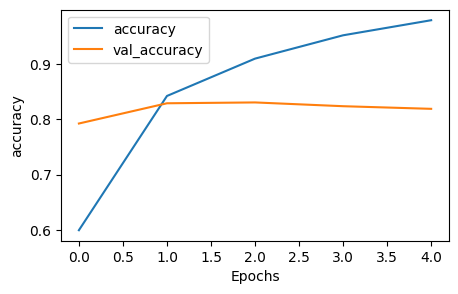

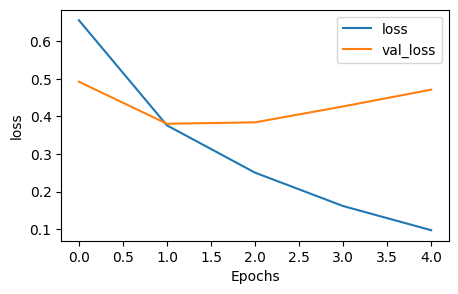

In [218]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

782/782 [==============================] - 2s 3ms/step - loss: 0.4714 - accuracy: 0.8192
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



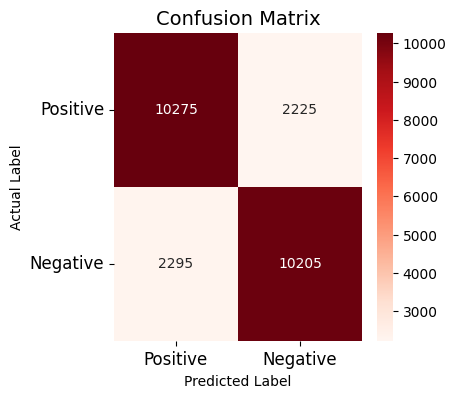

TP: 10275
TN: 10205
FP: 2225
FN: 2295


In [219]:
report(model)


**LSTM(Long Short-Term Memory,)**

In [158]:
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(lstm_dim),
    #tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 120, 16)           160000    
                                                                 
 lstm_4 (LSTM)               (None, 32)                6272      
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 166305 (649.63 KB)
Trainable params: 166305 (649.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [159]:
# Train the model
history_lstm = model_lstm.fit(padded, training_labels_final, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(testing_padded, testing_labels_final), callbacks=[epoch_callback, reduce_lr])

Epoch 1/5
196/196 [==============================] - 59s 111ms/step - loss: 0.5288 - accuracy: 0.7180 - val_loss: 0.4012 - val_accuracy: 0.8196 - lr: 0.0010
Epoch 2/5
196/196 [==============================] - 12s 60ms/step - loss: 0.3118 - accuracy: 0.8753 - val_loss: 0.3899 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 3/5
196/196 [==============================] - 7s 37ms/step - loss: 0.2474 - accuracy: 0.9056 - val_loss: 0.4301 - val_accuracy: 0.8202 - lr: 0.0010
Epoch 4/5
196/196 [==============================] - 6s 33ms/step - loss: 0.1995 - accuracy: 0.9271 - val_loss: 0.4603 - val_accuracy: 0.8104 - lr: 0.0010
Epoch 5/5
196/196 [==============================] - 5s 26ms/step - loss: 0.1325 - accuracy: 0.9580 - val_loss: 0.5130 - val_accuracy: 0.8140 - lr: 2.0000e-04


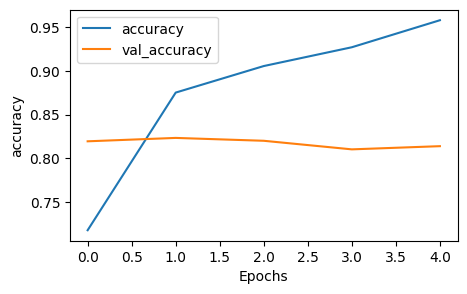

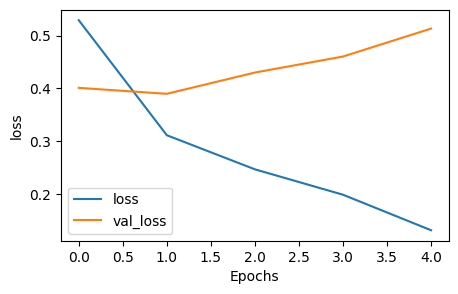

In [211]:
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

782/782 [==============================] - 3s 4ms/step - loss: 0.5130 - accuracy: 0.8140
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.79      0.85      0.82     12500
           1       0.84      0.78      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.82      0.81      0.81     25000
weighted avg       0.82      0.81      0.81     25000



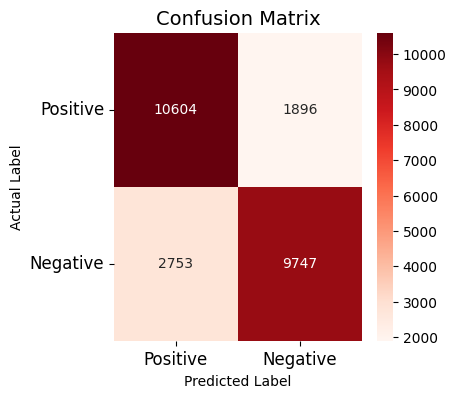

TP: 10604
TN: 9747
FP: 1896
FN: 2753


In [168]:
report(model_lstm)

**GRU(Gated Recurrent Unit)**

In [170]:
# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 120, 16)           160000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_31 (Dense)            (None, 6)                 390       
                                                                 
 dense_32 (Dense)            (None, 1)                 7         
                                                                 
Total params: 169997 (664.05 KB)
Trainable params: 169997 (664.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [171]:
history_gru = model_gru.fit(padded,
                            training_labels_final,
                            batch_size=BATCH_SIZE,
                            epochs=NUM_EPOCHS,
                            validation_data=(testing_padded, testing_labels_final))

Epoch 1/5
196/196 [==============================] - 29s 125ms/step - loss: 0.6077 - accuracy: 0.6445 - val_loss: 0.4405 - val_accuracy: 0.8045
Epoch 2/5
196/196 [==============================] - 11s 58ms/step - loss: 0.3379 - accuracy: 0.8588 - val_loss: 0.3986 - val_accuracy: 0.8292
Epoch 3/5
196/196 [==============================] - 11s 59ms/step - loss: 0.2536 - accuracy: 0.9024 - val_loss: 0.4033 - val_accuracy: 0.8217
Epoch 4/5
196/196 [==============================] - 9s 47ms/step - loss: 0.2062 - accuracy: 0.9246 - val_loss: 0.5122 - val_accuracy: 0.8140
Epoch 5/5
196/196 [==============================] - 5s 22ms/step - loss: 0.1634 - accuracy: 0.9431 - val_loss: 0.5330 - val_accuracy: 0.8114


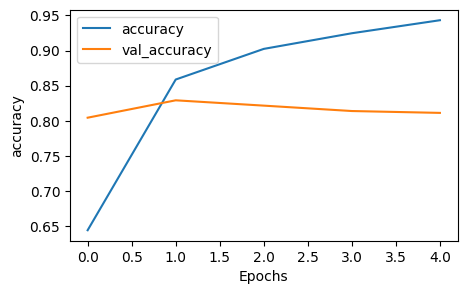

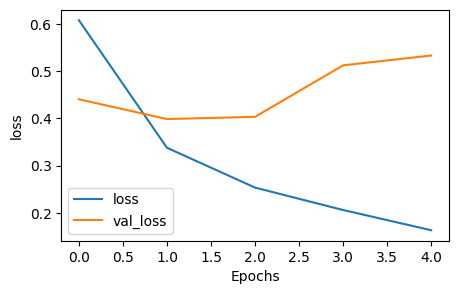

In [210]:
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

782/782 [==============================] - 4s 6ms/step - loss: 0.5330 - accuracy: 0.8114
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.81      0.81      0.81     12500
           1       0.81      0.81      0.81     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



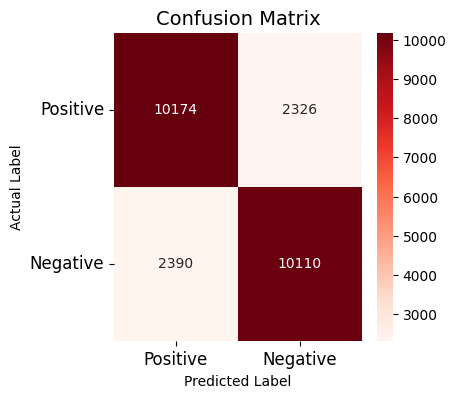

TP: 10174
TN: 10110
FP: 2326
FN: 2390


In [172]:
report(model_gru)

**Convolution RNN**

In [180]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_22 (Embedding)    (None, 120, 16)           160000    
                                                                 
 conv1d_3 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_3  (None, 128)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_39 (Dense)            (None, 6)                 774       
                                                                 
 dense_40 (Dense)            (None, 1)                 7         
                                                                 
Total params: 171149 (668.55 KB)
Trainable params: 171149 (668.55 KB)
Non-trainable params: 0 (0.00 Byte)
_____________

In [181]:
# Train the model
history_conv = model_conv.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final), callbacks=[reduce_lr])

Epoch 1/5
196/196 [==============================] - 22s 102ms/step - loss: 0.5246 - accuracy: 0.7446 - val_loss: 0.3897 - val_accuracy: 0.8241 - lr: 0.0010
Epoch 2/5
196/196 [==============================] - 11s 55ms/step - loss: 0.2999 - accuracy: 0.8738 - val_loss: 0.3836 - val_accuracy: 0.8294 - lr: 0.0010
Epoch 3/5
196/196 [==============================] - 5s 25ms/step - loss: 0.2401 - accuracy: 0.9043 - val_loss: 0.4082 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 4/5
196/196 [==============================] - 5s 26ms/step - loss: 0.2041 - accuracy: 0.9230 - val_loss: 0.4531 - val_accuracy: 0.8192 - lr: 0.0010
Epoch 5/5
196/196 [==============================] - 3s 18ms/step - loss: 0.1559 - accuracy: 0.9497 - val_loss: 0.4672 - val_accuracy: 0.8196 - lr: 2.0000e-04


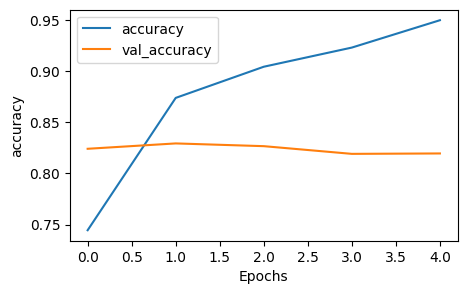

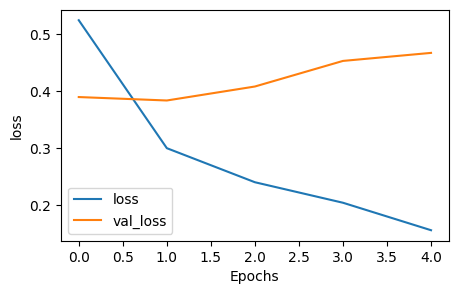

In [209]:
plot_graphs(history_conv, "accuracy")
plot_graphs(history_conv, "loss")

782/782 [==============================] - 3s 4ms/step - loss: 0.4672 - accuracy: 0.8196
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.82      0.82      0.82     12500
           1       0.82      0.82      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



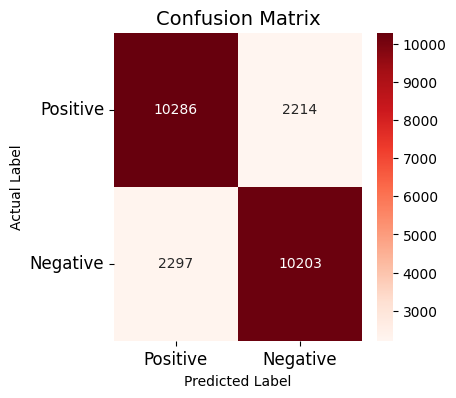

TP: 10286
TN: 10203
FP: 2214
FN: 2297


In [182]:
report(model_conv)

**Simple Recurrent Neural Networks (SRNNs)**

In [189]:
max_features = 20000
maxlen = 120
embedding_vector_length = 32

# Model Definition
model_srnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_srnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_srnn.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 120, 32)           640000    
                                                                 
 dropout_2 (Dropout)         (None, 120, 32)           0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_45 (Dense)            (None, 256)               8448      
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_46 (Dense)            (None, 1)                 257       
                                                                 
Total params: 650785 (2.48 MB)
Trainable params: 6507

In [190]:
# Train the model
history_srnn = model_srnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final),
                              callbacks=[reduce_lr, epoch_callback])

Epoch 1/5
196/196 [==============================] - 59s 292ms/step - loss: 0.6346 - accuracy: 0.6054 - val_loss: 0.4957 - val_accuracy: 0.7690 - lr: 0.0010
Epoch 2/5
196/196 [==============================] - 37s 190ms/step - loss: 0.3859 - accuracy: 0.8388 - val_loss: 0.4307 - val_accuracy: 0.8172 - lr: 0.0010
Epoch 3/5
196/196 [==============================] - 36s 182ms/step - loss: 0.2762 - accuracy: 0.8905 - val_loss: 0.6141 - val_accuracy: 0.8005 - lr: 0.0010
Epoch 4/5
196/196 [==============================] - 29s 149ms/step - loss: 0.1937 - accuracy: 0.9257 - val_loss: 0.5532 - val_accuracy: 0.8099 - lr: 0.0010
Epoch 5/5
196/196 [==============================] - 28s 144ms/step - loss: 0.0931 - accuracy: 0.9681 - val_loss: 0.6669 - val_accuracy: 0.8060 - lr: 2.0000e-04


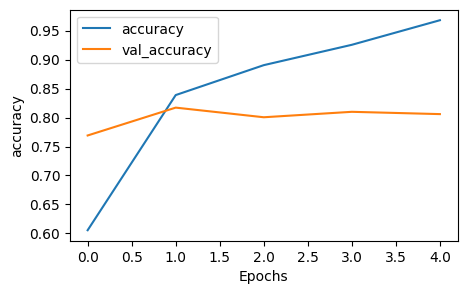

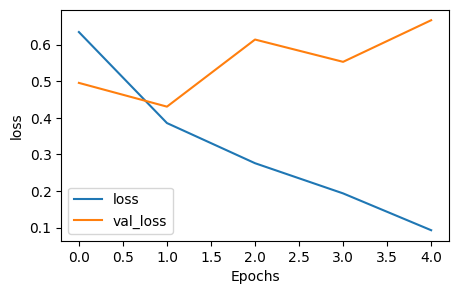

In [208]:
plot_graphs(history_srnn, "accuracy")
plot_graphs(history_srnn, "loss")

782/782 [==============================] - 9s 12ms/step - loss: 0.6669 - accuracy: 0.8060
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     12500
           1       0.82      0.78      0.80     12500

    accuracy                           0.81     25000
   macro avg       0.81      0.81      0.81     25000
weighted avg       0.81      0.81      0.81     25000



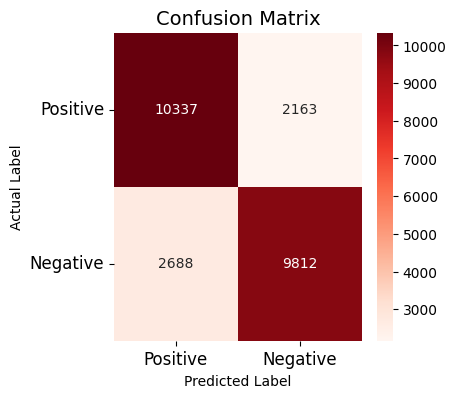

TP: 10337
TN: 9812
FP: 2163
FN: 2688


In [192]:
report(model_srnn)

**BRNN(Bidirectional Recurrent Neural Network)**

In [193]:
max_features = 20000
maxlen = 120
embedding_vector_length = 32

# Model Definition
model_brnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_brnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_brnn.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 120, 16)           160000    
                                                                 
 dropout_4 (Dropout)         (None, 120, 16)           0         
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                12544     
 onal)                                                           
                                                                 
 dense_47 (Dense)            (None, 256)               16640     
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_48 (Dense)            (None, 1)                 257       
                                                     

In [194]:
history_brnn = model_brnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/5
196/196 [==============================] - 170s 840ms/step - loss: 0.5032 - accuracy: 0.7313 - val_loss: 0.3905 - val_accuracy: 0.8240
Epoch 2/5
196/196 [==============================] - 12s 60ms/step - loss: 0.3039 - accuracy: 0.8742 - val_loss: 0.3960 - val_accuracy: 0.8201
Epoch 3/5
196/196 [==============================] - 8s 42ms/step - loss: 0.2478 - accuracy: 0.9039 - val_loss: 0.4108 - val_accuracy: 0.8153
Epoch 4/5
196/196 [==============================] - 8s 38ms/step - loss: 0.2133 - accuracy: 0.9200 - val_loss: 0.4277 - val_accuracy: 0.8150
Epoch 5/5
196/196 [==============================] - 6s 29ms/step - loss: 0.1951 - accuracy: 0.9274 - val_loss: 0.5280 - val_accuracy: 0.8018


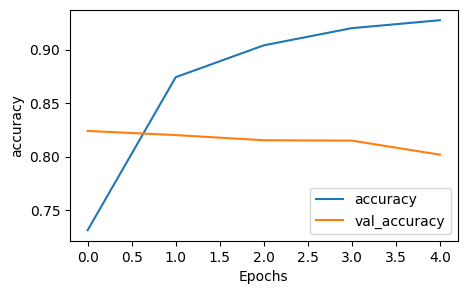

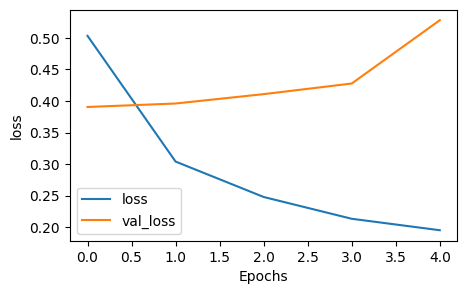

In [207]:
plot_graphs(history_brnn, "accuracy")
plot_graphs(history_brnn, "loss")

782/782 [==============================] - 5s 6ms/step - loss: 0.5280 - accuracy: 0.8018
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.76      0.88      0.82     12500
           1       0.86      0.72      0.78     12500

    accuracy                           0.80     25000
   macro avg       0.81      0.80      0.80     25000
weighted avg       0.81      0.80      0.80     25000



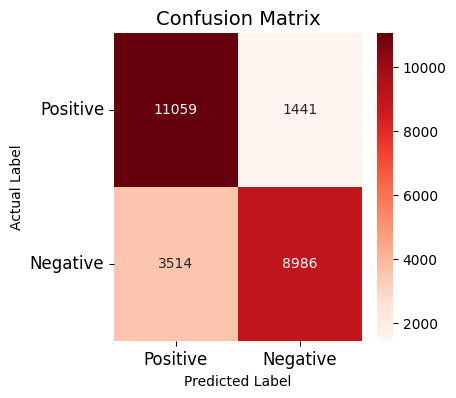

TP: 11059
TN: 8986
FP: 1441
FN: 3514


In [213]:
report(model_brnn)

**Deep BRNN**

In [200]:
max_features = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
embedding_vector_length = 32

# Model Definition
model_dbrnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_dbrnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_dbrnn.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 120, 32)           640000    
                                                                 
 dropout_11 (Dropout)        (None, 120, 32)           0         
                                                                 
 bidirectional_9 (Bidirecti  (None, 120, 128)          49664     
 onal)                                                           
                                                                 
 bidirectional_10 (Bidirect  (None, 128)               98816     
 ional)                                                          
                                                                 
 dense_53 (Dense)            (None, 256)               33024     
                                                                 
 dropout_12 (Dropout)        (None, 256)             

In [203]:
history_dbrnn = model_dbrnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final), callbacks=[reduce_lr, epoch_callback])

Epoch 1/5
196/196 [==============================] - 39s 158ms/step - loss: 0.5080 - accuracy: 0.7288 - val_loss: 0.3811 - val_accuracy: 0.8301 - lr: 0.0010
Epoch 2/5
196/196 [==============================] - 16s 82ms/step - loss: 0.3042 - accuracy: 0.8772 - val_loss: 0.4053 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 3/5
196/196 [==============================] - 12s 63ms/step - loss: 0.2499 - accuracy: 0.9046 - val_loss: 0.4539 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 4/5
196/196 [==============================] - 11s 57ms/step - loss: 0.1695 - accuracy: 0.9408 - val_loss: 0.4717 - val_accuracy: 0.8198 - lr: 2.0000e-04
Epoch 5/5
196/196 [==============================] - 10s 51ms/step - loss: 0.1498 - accuracy: 0.9485 - val_loss: 0.4987 - val_accuracy: 0.8162 - lr: 2.0000e-04


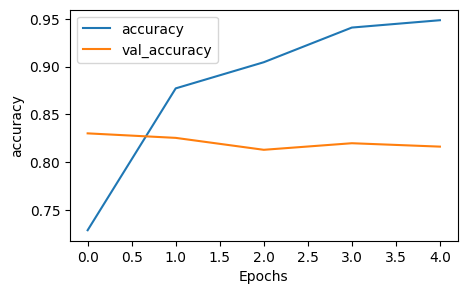

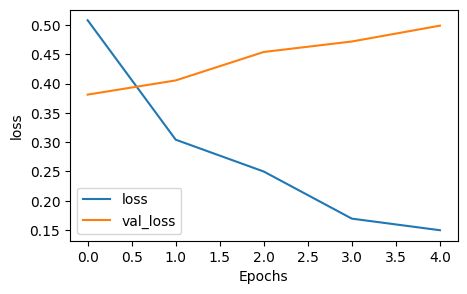

In [206]:
plot_graphs(history_dbrnn, "accuracy")
plot_graphs(history_dbrnn, "loss")

782/782 [==============================] - 8s 10ms/step - loss: 0.4987 - accuracy: 0.8162
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 0, Label: 0
Predicted: 0, Label: 0
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 1
Predicted: 1, Label: 0
Predicted: 0, Label: 1
              precision    recall  f1-score   support

           0       0.81      0.83      0.82     12500
           1       0.83      0.80      0.81     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



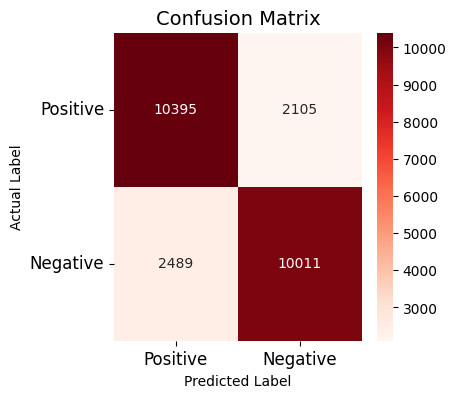

TP: 10395
TN: 10011
FP: 2105
FN: 2489


In [212]:
report(model_dbrnn)

All used neural networks showed a fairly high and relatively equal result. From the graphs, it was found that after the 3rd epoch, all neural networks underwent retraining. The neural network with the lowest validation loss and fairly high accuracy is Flatten.